In [1]:
# Change the list of artists to investigate using this list
artist_list = ["twenty one pilots", "billie eilish"]

In [2]:
# import necessary python modules
import numpy as np
import pandas as pd
import string
import requests
from requests.exceptions import HTTPError
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [3]:
def get_artist_id(artist_name):
    """
    Input: string, artist_name, name of the artist
    Output: string, artist_id, id of the most likely matching artist found at musicbrainz
    """
    url = "http://musicbrainz.org/ws/2/artist/?query=artist:" + artist_name + "&fmt=json"
    artist_id = ""
    try:
        response = requests.get(url)
        response.raise_for_status()
        jsonResponse = response.json()

        if len(jsonResponse["artists"]) > 0:
            for artist in jsonResponse["artists"]:
                if artist_name.lower().strip() == artist["name"].lower():
                    print("likely match found: " + artist["name"])
                    artist_id = artist["id"]
        else:
            print("no results found")

    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')

    return artist_id

In [4]:
def get_songs_for_artist_id(artist_id):
    """
    Input: string, artist id of the artist
    Output: list, unique songs found for the artist in musicbrainz
    """
    
    url = "https://beta.musicbrainz.org/ws/2/release/?query=arid:" + artist_id + "%20AND%20primarytype:Single&fmt=json"
    
    song_list = []
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        jsonResponse = response.json()

        if len(jsonResponse["releases"]) > 0:
            print("songs found")
            for release in jsonResponse["releases"]:
                song_title = release["title"]
                if not song_title in song_list and not "remix" in song_title.lower():
                    song_list.append(song_title)
        else:
            print("no songs found")
    
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
    
    return song_list

In [5]:
def get_lyrics_for_song(input_row):
    """
    Input: two strings, artist name, and the song name
    Output: lyrics for the song from api.lyrics.ovh, punctuation removed
    """
    artist_name = input_row["artist"]
    song_name = input_row["song_titles"]
    url = "https://api.lyrics.ovh/v1/" + artist_name + "/" + song_name
    
    song_lyrics = ""
    cleaned_lyrics = ""
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        jsonResponse = response.json()

        if len(jsonResponse["lyrics"]) > 0:
            print("lyrics found")
            song_lyrics = jsonResponse["lyrics"]
        else:
            print("no songs found")
    
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
        
    if len(song_lyrics) > 0:
        # Remove line breaks and punctuation
        for string_character in song_lyrics:
            # If char is not punctuation, add it to the result.
            if string_character not in string.punctuation:
                cleaned_lyrics += string_character
        cleaned_lyrics = cleaned_lyrics.split()
        number_of_words = len(cleaned_lyrics)
        # Convert lyrics to lowercase
        cleaned_lyrics = [word.lower() for word in cleaned_lyrics]
        cleaned_lyrics = " ".join(cleaned_lyrics)
        
    return cleaned_lyrics


In [6]:
#Create empty dataframe to store artist and songs
songs_df = pd.DataFrame(columns=["song_titles", "artist"])

for artist in artist_list:
    if len(artist) > 0:
        artist_id = get_artist_id(artist)
        song_list = get_songs_for_artist_id(artist_id)
        this_artist_df = pd.DataFrame(song_list, columns=["song_titles"])
        this_artist_df["artist"] = artist
        print(this_artist_df)
        #songs_df.append(this_artist_df) 
        songs_df = pd.concat([songs_df, this_artist_df], ignore_index=True)

likely match found: twenty one pilots
songs found
                           song_titles             artist
0                         Fake You Out  twenty one pilots
1                        House of Gold  twenty one pilots
2                             Lane Boy  twenty one pilots
3       Jumpsuit / Nico and the Niners  twenty one pilots
4                               Lovely  twenty one pilots
5                               Cancer  twenty one pilots
6   Cut My Lip (40.6782°N, 73.9442° W)  twenty one pilots
7                         Fairly Local  twenty one pilots
8                    Holding On to You  twenty one pilots
9                             Chlorine  twenty one pilots
10                  The Hype (alt mix)  twenty one pilots
11                    Tear in My Heart  twenty one pilots
12                      Guns for Hands  twenty one pilots
13   Chlorine (19.4326° N, 99.1332° W)  twenty one pilots
14                            My Blood  twenty one pilots
15                 Tim

In [7]:
songs_df["lyrics"] = songs_df.apply(get_lyrics_for_song, axis=1)

lyrics found
lyrics found
lyrics found
HTTP error occurred: 404 Client Error: Not Found for url: https://api.lyrics.ovh/v1/twenty%20one%20pilots/Jumpsuit%20/%20Nico%20and%20the%20Niners
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
HTTP error occurred: 404 Client Error: Not Found for url: https://api.lyrics.ovh/v1/billie%20eilish/Billie%20Eilish%20Live%20at%20the%20Steve%20Jobs%20Theater
lyrics found
lyrics found
lyrics found
HTTP error occurred: 404 Client Error: Not Found for url: https://api.lyrics.ovh/v1/billie%20eilish/WHEN%20I%20WAS%20OLDER:%20Music%20Inspired%20by%20the%20Film%20Roma
lyrics found
lyrics found
lyrics found
HTTP error occurred: 404 Client Error: Not Found for url: https://api.lyrics.ovh/v1/billie%20eilish/&burn
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found
lyrics found


In [8]:
# Drop songs which do not have any lyrics (or none found)
rows_to_drop = songs_df[ songs_df["lyrics"] == "" ].index
 
# Delete these row indexes from dataFrame
songs_df.drop(rows_to_drop , inplace=True)

In [9]:
# Calculate the number of words in each song
songs_df["number_of_words"] = songs_df["lyrics"].apply(lambda x: len(x.split(" ")))

In [10]:
# Show statistics for number of words by artist
songs_df.groupby(["artist"], as_index=False).agg({"number_of_words":['mean','var','std']})

artist number_of_words                        
                                mean          var        std
0      billie eilish      205.266667  2312.209524  48.085440
1  twenty one pilots      358.235294  6771.691176  82.290286

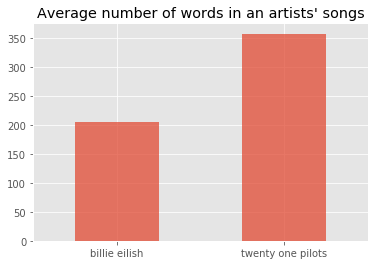

In [11]:
# Plot the mean number of words in a bar chart
matplotlib.style.use('ggplot')
songs_df.groupby(["artist"]).agg({"number_of_words":['mean']}).plot(kind='bar',alpha=0.75, rot=0)
plt.xlabel("")
plt.legend().set_visible(False)
plt.title("Average number of words in an artists' songs")
plt.show()

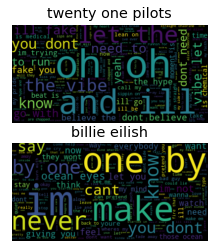

In [12]:
# Word clouds of most common words in the lyrics
i = 0
for artist in artist_list:
    artist_words = ' '.join(songs_df[songs_df["artist"] == artist]["lyrics"])
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(artist_words)

    # Display the generated image:
    ax= plt.subplot(2, 1, i+1)
    im=ax.imshow(wordcloud, interpolation='bilinear')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title(artist)

    i += 1
    